In [1]:
#Mounting on co-lab
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.insert(0,'/content/drive/My Drive/Interpretable_DNN/Revision') # change folder name

Mounted at /content/drive


In [2]:
#Import of Libaries

import os
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import math
import itertools
import pickle
from numpy.ma.core import argmax

#Model Building and Explanations
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, backend, Model, callbacks
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.regularizers import l2
from sklearn.metrics import confusion_matrix, classification_report,roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go


#plots
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go



#custom functions
from functions.data_proc import *
from functions.experiment_setup import *
from functions.generate_inputs import *
from functions.model import *


### Experiment

In [3]:
#Experimental parameters
prediction = 'Outcome' 
experiment =  'AG' #'AG_LS' #'AG','MS', 'IX'
timelapsed = 'total'


#Directories
MY_WORKSPACE_DIR = "/content/drive/My Drive/Interpretable_DNN/Revision/BPIC18"
MILESTONE_DIR = MY_WORKSPACE_DIR+'/'+experiment+'/'

#Dataset
file_name = os.path.join(MY_WORKSPACE_DIR,'BPIC_2018_OUTCOME.csv')
log_name = 'BPIC_2018'


#saving parameters to a dictionary
args = get_parameters(MILESTONE_DIR, MY_WORKSPACE_DIR, prediction, experiment, file_name, log_name,None)


In [4]:
### feature categories
cat_dynamic = ['ACTIVITY','ROLE']
num_dynamic = ['TASK_DURATION','TIME_ELAPSED'] 
cat_static = [] 
num_static = ['AMOUNT_REQ']
activity_name = 'ACTIVITY'


### Loading Model Explanations, Pre-processing and Saving

In [5]:
#files

#model explanations
file_explanations = os.path.join(MILESTONE_DIR,log_name+'_'+experiment+'_explanations.csv')

#LR explanations
file_explanations_LR = os.path.join(MILESTONE_DIR,os.path.join('EVAL',log_name+'_'+experiment+'_LR_explanations.csv'))

#DL explanations
file_explanations_DL = os.path.join(MILESTONE_DIR,os.path.join('EVAL',log_name+'_'+experiment+'_DL_explanations.csv'))

#loading dataframes

#model explanations
df_explanations = pd.read_csv(file_explanations).reset_index(drop = True)
df_explanations = df_explanations.iloc[:,1:]

#LR explanations
df_explanations_LR = pd.read_csv(file_explanations_LR).reset_index(drop = True)
df_explanations_LR = df_explanations_LR.iloc[:,1:]


#DL explanations
df_explanations_DL = pd.read_csv(file_explanations_DL).reset_index(drop = True)
df_explanations_DL = df_explanations_DL.iloc[:,1:]
df_explanations_DL['ACTIVITY_INDEX'] = df_explanations_DL['FEATURE'].str.split().str[-1].astype(int)



In [6]:
#predictions

#model predictions
file_predictions = os.path.join(MILESTONE_DIR,log_name+'_'+experiment+'_predictions.csv')

#DL predictions
file_predictions_DL = os.path.join(MILESTONE_DIR,os.path.join('EVAL',log_name+'_'+experiment+'_DL_predictions.csv'))

#loading dataframes

#model predictions
df_predictions = pd.read_csv(file_predictions).reset_index(drop = True)
df_predictions = df_predictions.iloc[:,1:]


#DL predictions
df_predictions_DL = pd.read_csv(file_predictions_DL).reset_index(drop = True)
df_predictions_DL = df_predictions_DL.iloc[:,1:]



In [7]:
df_explanations = df_explanations.merge(df_predictions, on = ['BUCKET','CASEID'])
df_explanations_DL = df_explanations_DL.merge(df_predictions_DL, on = ['BUCKET','CASEID'])


In [8]:
df_test = pd.read_csv(MY_WORKSPACE_DIR+'/BPIC_2018_log_df_test.csv')
df_test_attributes = df_test[['CASEID','BUCKET','AMOUNT_REQ','TIME_ELAPSED','TASK_DURATION']]

df_amount = df_test.groupby(['BUCKET','CASEID'])['AMOUNT_REQ'].mean().reset_index()
df_time_elapsed = df_test.groupby(['BUCKET','CASEID'])['TIME_ELAPSED'].max().reset_index()
df_task_duration = df_test.groupby(['BUCKET','CASEID'])['TASK_DURATION'].mean().reset_index()

df_test_attributes = df_amount.merge(df_time_elapsed, on = ['BUCKET','CASEID'])
df_test_attributes = df_test_attributes.merge(df_task_duration, on = ['BUCKET','CASEID'])



In [9]:
df_test_attributes_event = df_test[['BUCKET','CASEID','AMOUNT_REQ','TIME_ELAPSED','TASK_DURATION','ACTIVITY_INDEX']].drop_duplicates()


In [10]:
#saving the explanations
#local_case_level
df_explanations = df_explanations.merge(df_test_attributes, on = ['BUCKET','CASEID'])
df_explanations.to_csv(MILESTONE_DIR+'/bpic_2018_local_case_level.csv', index = False)

#local_event_level
df_explanations_DL = df_explanations_DL.merge(df_test_attributes_event, on = ['BUCKET','CASEID','ACTIVITY_INDEX'])
df_explanations_DL.to_csv(MILESTONE_DIR+'/bpic_2018_local_event_level.csv', index = False)


### Visualization of Explanations

Text(0.5, 0.98, 'Global Explanation')

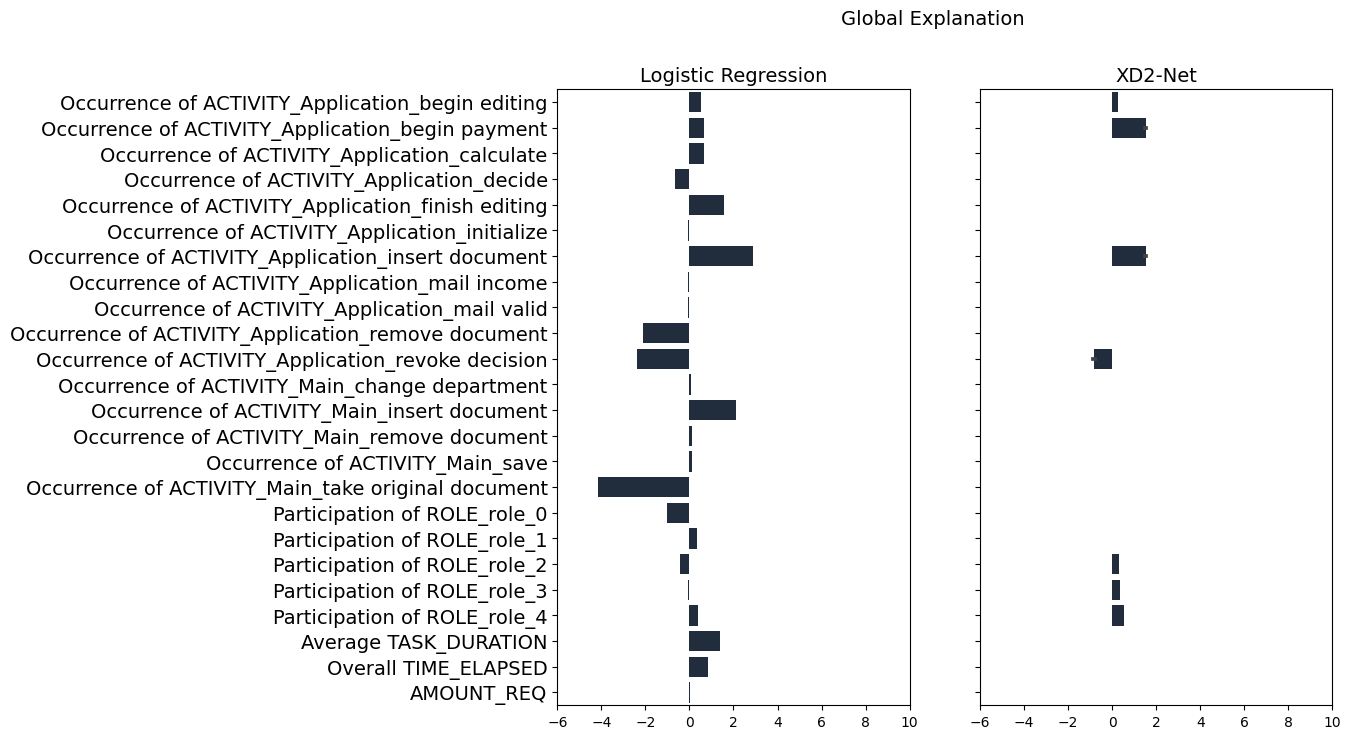

In [11]:
#Global Explanations

bucket = '1_15'
color_a = '#1c2b42' #'#47a0b3' #,'#1c2b42'


local_case_level = df_explanations.loc[df_explanations['BUCKET'] == bucket]
global_case_level = df_explanations_LR.loc[df_explanations_LR['BUCKET'] == bucket]
local_event_level = df_explanations_DL.loc[df_explanations_DL['BUCKET'] == bucket]

fig, axes = plt.subplots(1,2,figsize=(10,8))
df_t = local_case_level.copy()
df_t2 = global_case_level.copy()

sn.barplot(data=df_t2 ,y='FEATURE',x = 'FEATURE_IMPORTANCE', color = color_a, ax = axes[0])
axes[0].set_yticklabels(df_t2['FEATURE'], rotation=0,fontsize=14)
axes[0].set_title('Logistic Regression',fontsize=14)
axes[0].set(ylabel= None)
axes[0].set(xlabel= None)
axes[0].set_xlim([-6,10])


sn.barplot(data=df_t ,y='FEATURE',x = 'FEATURE_IMPORTANCE', color = color_a, ax = axes[1])
axes[1].set(yticklabels=[])
axes[1].set(ylabel= None)
axes[1].set(xlabel= None)
axes[1].set_title('XD2-Net',fontsize=14)
axes[1].set_xlim([-6, 10])

fig.suptitle('Global Explanation',fontsize=14)

Text(0.5, 0.98, 'Global Explanation')

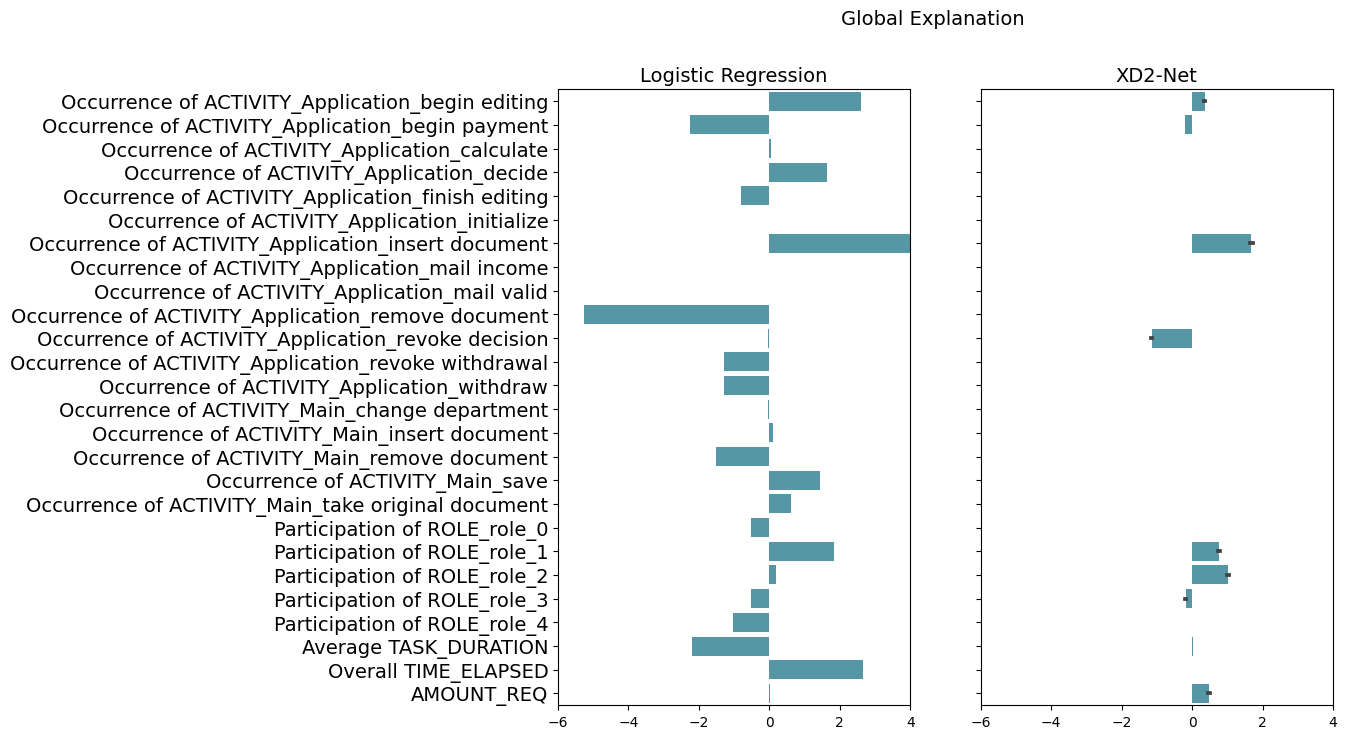

In [12]:
#Global Explanations

bucket = '1_20'
color_a = '#47a0b3' #'#47a0b3' #,'#1c2b42'


local_case_level = df_explanations.loc[df_explanations['BUCKET'] == bucket]
global_case_level = df_explanations_LR.loc[df_explanations_LR['BUCKET'] == bucket]
local_event_level = df_explanations_DL.loc[df_explanations_DL['BUCKET'] == bucket]

fig, axes = plt.subplots(1,2,figsize=(10,8))
df_t = local_case_level.copy()
df_t2 = global_case_level.copy()

sn.barplot(data=df_t2 ,y='FEATURE',x = 'FEATURE_IMPORTANCE', color = color_a, ax = axes[0])
axes[0].set_yticklabels(df_t2['FEATURE'], rotation=0,fontsize=14)
axes[0].set_title('Logistic Regression',fontsize=14)
axes[0].set(ylabel= None)
axes[0].set(xlabel= None)
axes[0].set_xlim([-6, 4])


sn.barplot(data=df_t ,y='FEATURE',x = 'FEATURE_IMPORTANCE', color = color_a, ax = axes[1])
axes[1].set(yticklabels=[])
axes[1].set(ylabel= None)
axes[1].set(xlabel= None)
axes[1].set_title('XD2-Net',fontsize=14)
axes[1].set_xlim([-6, 4])

fig.suptitle('Global Explanation',fontsize=14)

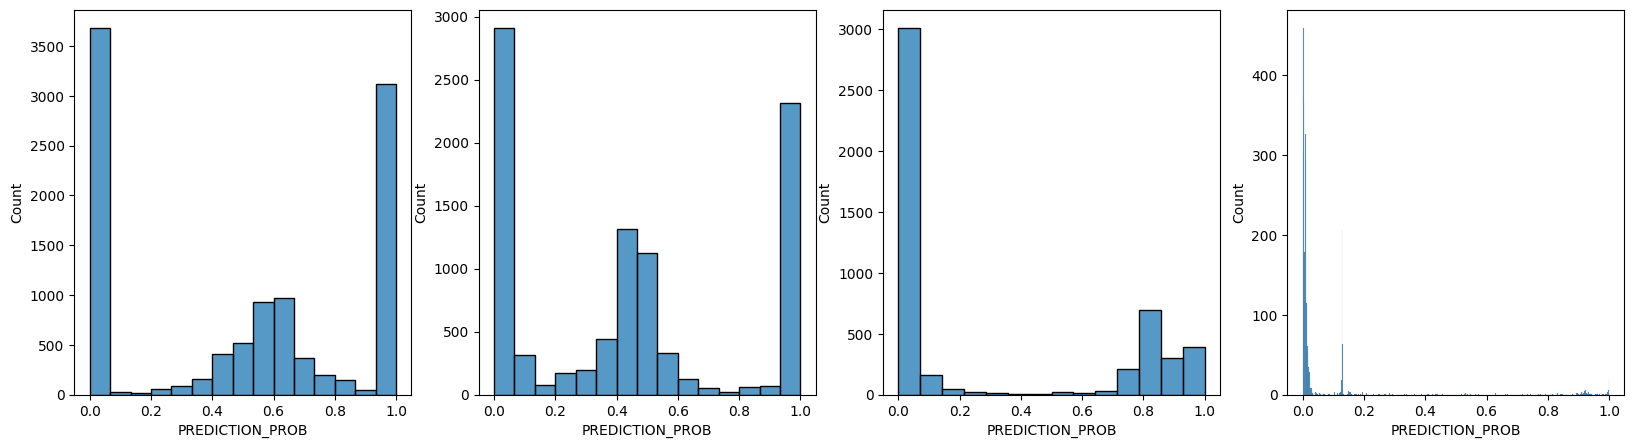

In [13]:
#Distribution of Predictions
#XD2 Net

buckets = ['1_12','1_15','1_20','1_25']
fig,axes = plt.subplots(1,4 ,figsize = (20,5))
for i,bucket in enumerate(buckets):
  df_t = df_predictions.loc[df_predictions['BUCKET']== bucket]
  sn.histplot(data = df_t, x = 'PREDICTION_PROB',ax = axes[i])

plt.show() 

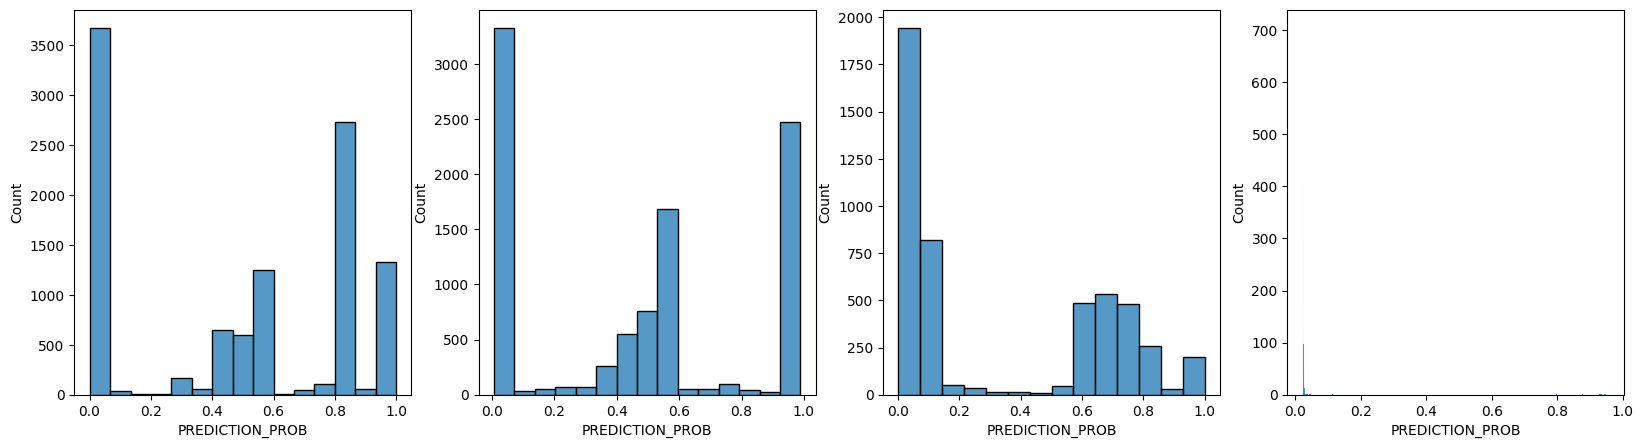

In [14]:
#Deep Learning
buckets = ['1_12','1_15','1_20','1_25']
fig,axes = plt.subplots(1,4 ,figsize = (20,5))
for i,bucket in enumerate(buckets):
  df_t = df_predictions_DL.loc[df_predictions['BUCKET']== bucket]
  sn.histplot(data = df_t, x = 'PREDICTION_PROB',ax = axes[i])

plt.show() 

<Axes: xlabel='PREDICTION_PROB_XD2_Net', ylabel='PREDICTION_PROB_DL'>

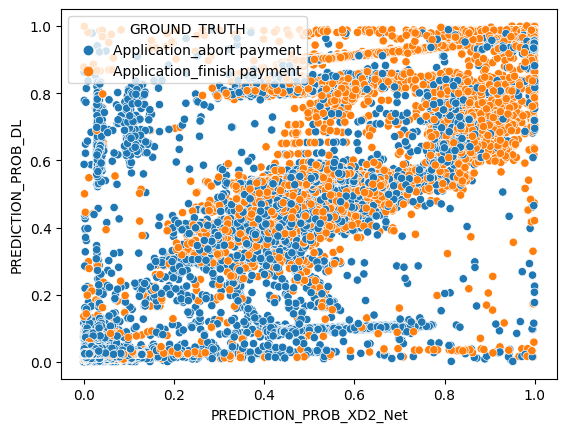

In [15]:
#overlap between the XD2 net and DL models
df_temp = df_predictions[['CASEID','BUCKET','PREDICTION_PROB']].merge(df_predictions_DL[['CASEID','BUCKET','PREDICTION_PROB','GROUND_TRUTH']], on = ['CASEID','BUCKET'])
df_temp.columns = ['CASEID','BUCKET','PREDICTION_PROB_XD2_Net','PREDICTION_PROB_DL','GROUND_TRUTH']


sn.scatterplot(data =df_temp, x='PREDICTION_PROB_XD2_Net', y ='PREDICTION_PROB_DL', hue ='GROUND_TRUTH' )

In [ ]:
df_temp.to_csv(MILESTONE_DIR+'/bpic_2018_cases.csv', index = False)

### Evaluation of Global Explanations - Effective Complexity and Feature Agreement

#### Feature Agreement

https://doi.org/10.48550/arXiv.2202.01602

###### Specify Buckets

In [16]:
#Specify the buckets for which we do the evaluation
buckets = ['1_5','1_12','1_15','1_20','1_25'] #['1_5','1_10','1_15','1_20']

###### Iterate over buckets - Feature agreement and Rank agreement

<ipython-input-17-3dcce4c290dd>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  global_case_level.loc[:,'RANK'] = global_case_level['FEATURE_IMPORTANCE'].rank(method = 'dense', ascending = False)


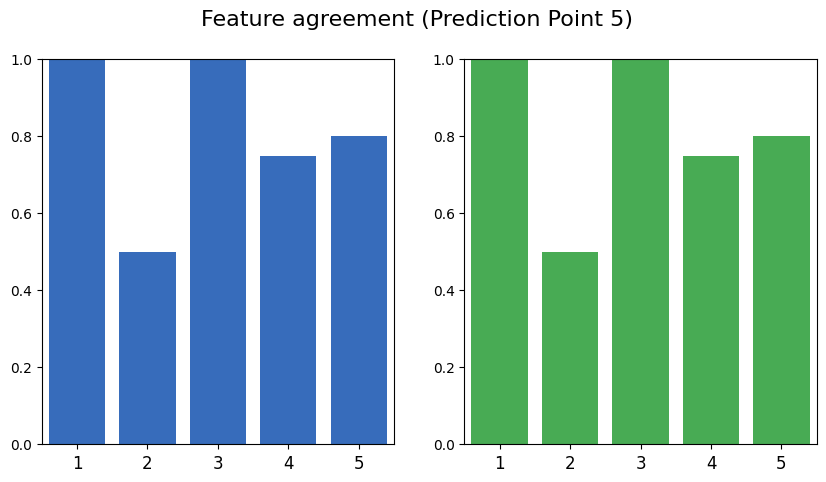

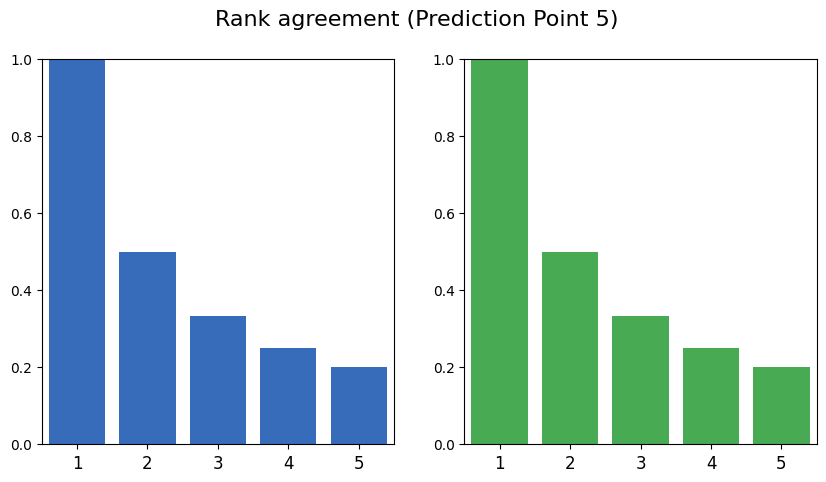

<ipython-input-17-3dcce4c290dd>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  global_case_level.loc[:,'RANK'] = global_case_level['FEATURE_IMPORTANCE'].rank(method = 'dense', ascending = False)


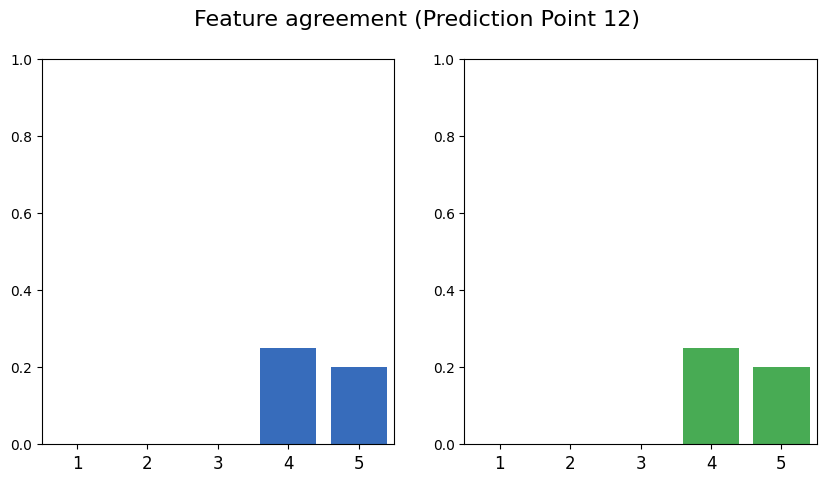

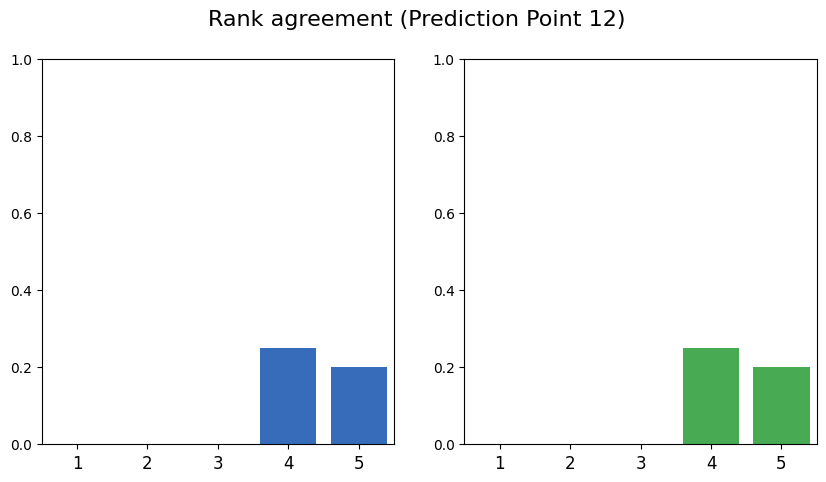

<ipython-input-17-3dcce4c290dd>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  global_case_level.loc[:,'RANK'] = global_case_level['FEATURE_IMPORTANCE'].rank(method = 'dense', ascending = False)


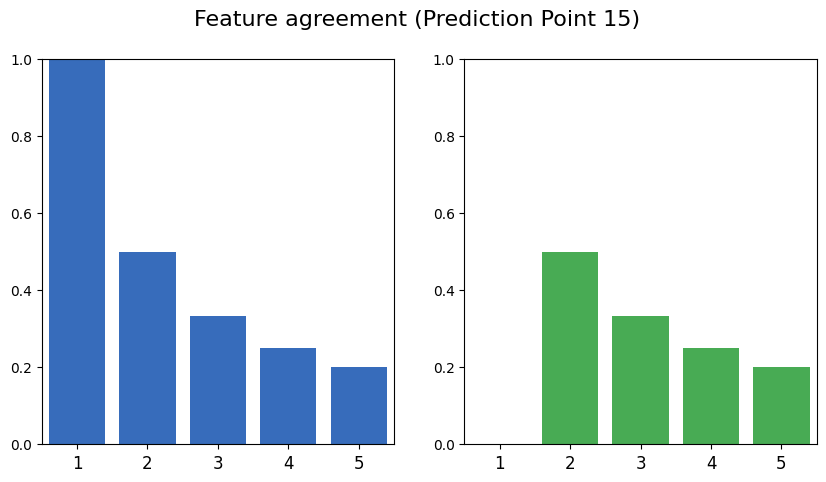

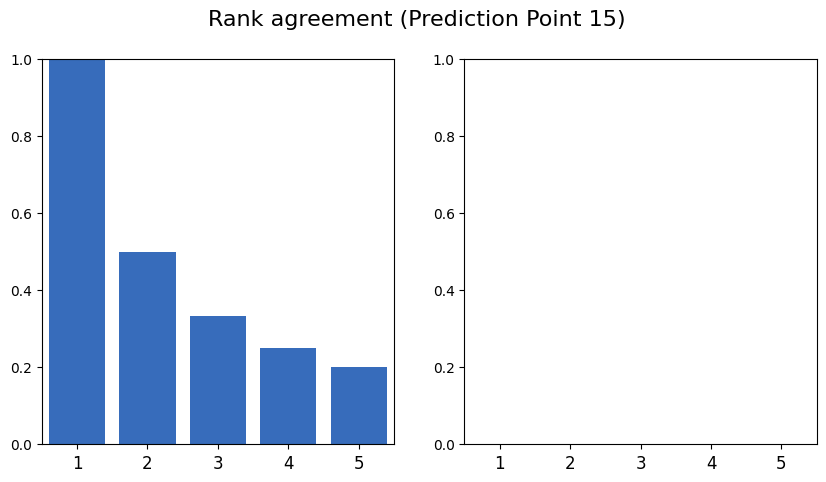

<ipython-input-17-3dcce4c290dd>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  global_case_level.loc[:,'RANK'] = global_case_level['FEATURE_IMPORTANCE'].rank(method = 'dense', ascending = False)


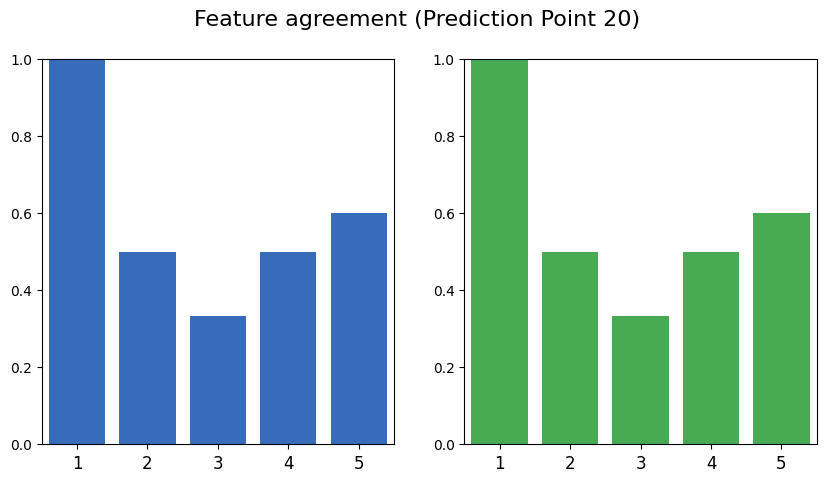

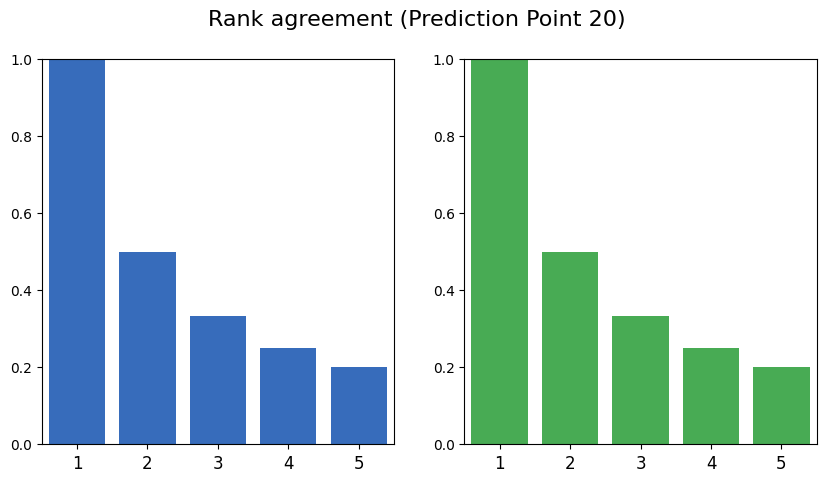

<ipython-input-17-3dcce4c290dd>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  global_case_level.loc[:,'RANK'] = global_case_level['FEATURE_IMPORTANCE'].rank(method = 'dense', ascending = False)


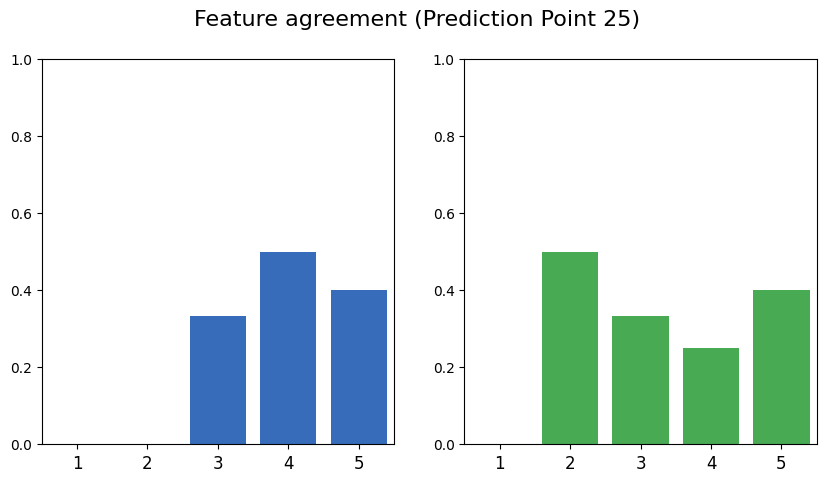

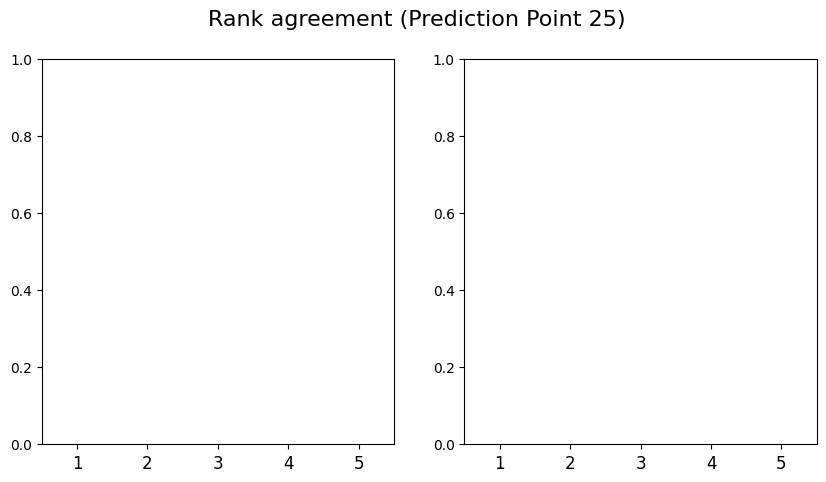

In [17]:
color_list = ['#2168D1','#37BB47']

for bucket in buckets:
  local_case_level = df_explanations.loc[df_explanations['BUCKET'] == bucket]
  global_case_level = df_explanations_LR.loc[df_explanations_LR['BUCKET'] == bucket]

  #specify three levels of aggregation of local case level explanations to global explanation
  global_case_level_ag_mean = local_case_level.groupby(['BUCKET','FEATURE'])['FEATURE_IMPORTANCE'].mean().reset_index()
  global_case_level_ag_median = local_case_level.groupby(['BUCKET','FEATURE'])['FEATURE_IMPORTANCE'].median().reset_index()
  global_case_level_ag_max = local_case_level.groupby(['BUCKET','FEATURE'])['FEATURE_IMPORTANCE'].max().reset_index()

  #rank the features based on the feature importance
  global_case_level.loc[:,'RANK'] = global_case_level['FEATURE_IMPORTANCE'].rank(method = 'dense', ascending = False)
  global_case_level_ag_mean.loc[:,'RANK'] = global_case_level_ag_mean['FEATURE_IMPORTANCE'].rank(method = 'dense', ascending = False)
  global_case_level_ag_median.loc[:,'RANK'] = global_case_level_ag_median['FEATURE_IMPORTANCE'].rank(method = 'dense', ascending = False)
  global_case_level_ag_max.loc[:,'RANK'] = global_case_level_ag_max['FEATURE_IMPORTANCE'].rank(method = 'dense', ascending = False)

  #Feature agreement
  fig, axes = plt.subplots(1,2,figsize=(10,5))

  for j, df in enumerate([global_case_level_ag_mean,global_case_level_ag_median]): 

    titles = ['XD2 net (mean)','XD2 net (median)']
    feature_agreement = []
    top_k_features = list(range(1,6))

    for i in range(5):
      df_t = df.loc[df['RANK'] <=i+1]
      df_t2 = global_case_level.loc[global_case_level['RANK']<=i+1]
      df_t = df_t.merge(df_t2, on = 'FEATURE')
      feature_agreement.append(len(df_t)/(i+1))

      #plot
    sn.barplot(y=feature_agreement ,x = top_k_features , color = color_list[j], ax = axes[j])
    axes[j].set_xticklabels(top_k_features, fontsize = 12)
    #axes[j].set_title(titles[j],fontsize=14)
    axes[j].set_ylim([0, 1])

  fig.suptitle('Feature agreement (Prediction Point '+ bucket.split('_')[1]+')',fontsize=16)
  plt.show()

  #Rank agreement
  fig, axes = plt.subplots(1,2,figsize=(10,5))

  for j, df in enumerate([global_case_level_ag_mean,global_case_level_ag_median]): 

    titles = ['XD2 net (mean)','XD2 net (median)']
    feature_agreement = []
    top_k_features = list(range(1,6))

    for i in range(5):
      df_t = df.loc[df['RANK'] <=i+1]
      df_t2 = global_case_level.loc[global_case_level['RANK']<=i+1]
      df_t = df_t.merge(df_t2, on = ['FEATURE','RANK'])
      feature_agreement.append(len(df_t)/(i+1))

      #plot
    sn.barplot(y=feature_agreement ,x = top_k_features , color = color_list[j], ax = axes[j])
    axes[j].set_xticklabels(top_k_features, fontsize = 12)
    #axes[j].set_title(titles[j],fontsize=14)
    axes[j].set_ylim([0, 1])
  
  fig.suptitle('Rank agreement (Prediction Point '+ bucket.split('_')[1]+')',fontsize=16)
  plt.show()

#### Effective Complexity

###### Specify Buckets

In [ ]:
#Specify the buckets for which we do the evaluation
buckets = ['1_5','1_12','1_15','1_20','1_25']
n_sizes = [5,12,15,20,25]

###### Generate model inputs

In [ ]:
#For this evaluation we will require to load the feature vectors in each of these buckets and generate inputs
with open(args['processed_vec'], 'rb') as fp:
    full_vec = pickle.load(fp)

with open(args['indexes'], 'rb') as fp:
    indexes = pickle.load(fp)

with open(args['bucket_info'], 'rb') as fp:
    bucket_info = pickle.load(fp)

inputs_outputs = {} #Final Dictionary with Test and Train Inputs/ Outputs for all buckets

for i in range(len(buckets)):

  vec_train = full_vec[buckets[i]]['vec_train']
  vec_test = full_vec[buckets[i]]['vec_test']

  #removing amt_req feature

  #vec_train['statics']['amt_req'] =  np.absolute(vec_train['statics']['amt_req'])*0
  #vec_test['statics']['amt_req'] =  np.absolute(vec_test['statics']['amt_req'])*0
  

  bucket = buckets[i]
  bucket_inputs_outputs  = {}

  #Inputs and Outputs -- select depending on the encoding technique
  
  inputs_train, outputs_train, input_exp_dim_train, features_exp_train = generate_inputs_AG(vec_train,indexes[bucket],n_sizes[i],cat_dynamic, num_dynamic,cat_static,num_static)
  inputs_test, outputs_test, input_exp_dim_test, features_exp_test = generate_inputs_AG(vec_test,indexes[bucket],n_sizes[i],cat_dynamic, num_dynamic,cat_static,num_static)


  features_exp = features_exp_train
  input_exp_dim = input_exp_dim_train
  if len(features_exp_test) > len(features_exp_train):
    features_exp = features_exp_test
    input_exp_dim = input_exp_dim_test

    #if training feature dimensionality < test feature dimensionalty, reshape the training feature dimensionality (this can happen when sample size is too small)
    input_exp_temp =[]
    for i in range(inputs_train['input_exp'].shape[0]):
      feat =[]
      k = 0
      for j in range(len(features_exp)):
        if features_exp[j] == features_exp_train[k]:
          feat.append(inputs_train['input_exp'][i][k])
          k = k+1
        else:
          feat.append(0)
      input_exp_temp.append(feat)
    input_exp_temp = np.asarray(input_exp_temp) 
    inputs_train['input_exp'] = input_exp_temp

  if len(features_exp_test) < len(features_exp_train):
    #if test feature dimensionality < training feature dimensionalty, reshape the test feature dimensionality (this can happen when sample size is too small)
    input_exp_temp =[]
    for i in range(inputs_test['input_exp'].shape[0]):
      feat =[]
      k = 0
      for j in range(len(features_exp)):
        if features_exp[j] == features_exp_test[k]:
          feat.append(inputs_test['input_exp'][i][k])
          k = k+1
        else:
          feat.append(0)
      input_exp_temp.append(feat)
    input_exp_temp = np.asarray(input_exp_temp) 
    inputs_test['input_exp'] = input_exp_temp

  bucket_inputs_outputs['inputs_train'] = inputs_train
  bucket_inputs_outputs['inputs_test'] = inputs_test
  bucket_inputs_outputs['outputs_train'] = outputs_train
  bucket_inputs_outputs['outputs_test'] = outputs_test
  bucket_inputs_outputs['explainable_feature_names'] = features_exp
  bucket_inputs_outputs['input_exp_dim'] = input_exp_dim

  inputs_outputs[bucket] = bucket_inputs_outputs
  
  dynamic_dim = bucket_inputs_outputs['inputs_train']['input_dynamic'].shape[2]
  try: static_dim = bucket_inputs_outputs['inputs_train']['input_static'].shape[1]
  except: static_dim  = 1

  print(bucket+' done!')
  print(inputs_train['input_dynamic'].shape)
  print(static_dim)
  print(input_exp_dim)


1_5 done!
(23920, 5, 12)
1
13
1_12 done!
(23918, 12, 23)
1
24
1_15 done!
(20918, 15, 23)
1
24
1_20 done!
(6914, 20, 25)
1
26
1_25 done!
(4592, 25, 26)
1
27


###### Iterate over buckets

In [ ]:
epsilon = 0.5
prefix_bucket_XD2 = []
effective_complexity_XD2 = []
rmse_XD2 = []
prefix_bucket_LR = []
effective_complexity_LR = []
rmse_LR = []

for bucket in buckets:

  local_case_level = df_explanations.loc[df_explanations['BUCKET'] == bucket]
  global_case_level = df_explanations_LR.loc[df_explanations_LR['BUCKET'] == bucket]

  #get the order of the inputs
  global_exp_LR = global_case_level.groupby('FEATURE')['FEATURE_IMPORTANCE'].mean().reset_index()
  global_exp_XD2_net = local_case_level.groupby('FEATURE')['FEATURE_IMPORTANCE'].mean().reset_index()

  #rank the features based on the absolute feature importance
  global_exp_LR['RANK'] = global_exp_LR['FEATURE_IMPORTANCE'].abs().rank()
  global_exp_XD2_net['RANK'] = global_exp_XD2_net['FEATURE_IMPORTANCE'].abs().rank()

  #generate a dataframe with the correct order of features and ranks
  features_exp = inputs_outputs[bucket]['explainable_feature_names']
  df_feature_ranks = pd.DataFrame({'FEATURE':features_exp})
  df_feature_ranks = df_feature_ranks.merge(global_exp_LR[['FEATURE','RANK']], on = 'FEATURE')
  df_feature_ranks.columns = ['FEATURE','LR_RANK']
  df_feature_ranks = df_feature_ranks.merge(global_exp_XD2_net[['FEATURE','RANK']], on = 'FEATURE')

  #load inputs outputs
  input_test = inputs_outputs[bucket]['inputs_test']
  output_test = inputs_outputs[bucket]['outputs_test']
  input_train = inputs_outputs[bucket]['inputs_train']
  output_train = inputs_outputs[bucket]['outputs_train']
  exp_dim = input_test['input_exp'].shape[1]

  #Evaluation for XD2 Net----------------------------------------------------------------------------------------------------------------

  #load original model
  model_XD_file =  os.path.join(MILESTONE_DIR,'_model_'+ bucket +'.pkl')
  with open(model_XD_file, 'rb') as f:
    xd_model = pickle.load(f)

  #original output
  y_pred_original =  xd_model.predict([input_test['input_dynamic'],input_test['input_static'],input_test['input_exp']])[1].flatten()


  
  #iterate over features 
  for i in range(len(features_exp)-1):

    indexes = list(df_feature_ranks[df_feature_ranks['RANK'] <= i+1].index)
    dynamic_indexes = [x for x in indexes if x < input_train['input_dynamic'].shape[2]]
    static_indexes = [input_train['input_dynamic'].shape[2]-x for x in indexes if x >= input_train['input_dynamic'].shape[2]]


    #delete the least significant features
    input_train_exp_temp = np.delete(input_train['input_exp'], indexes, axis=1)
    input_test_exp_temp = np.delete(input_test['input_exp'], indexes, axis=1)

    input_train_dynamic_temp = np.delete(input_train['input_dynamic'], dynamic_indexes, axis=2)
    input_test_dynamic_temp = np.delete(input_test['input_dynamic'], dynamic_indexes, axis=2)

    input_train_static_temp = np.delete(input_train['input_static'], static_indexes, axis=1)
    input_test_static_temp = np.delete(input_test['input_static'], static_indexes, axis=1)

    if input_train_dynamic_temp.shape[2] == 0:
      print('XD2_Net fails')
      break
    else:    
    
        #create new inputs with ablated features
        input_test_temp = {'input_dynamic': input_test_dynamic_temp,'input_static': input_test_static_temp, 'input_exp': input_test_exp_temp}
        input_train_temp = {'input_dynamic': input_train_dynamic_temp,'input_static': input_train_static_temp, 'input_exp': input_train_exp_temp}

        #build and train new models for the new inputs
        lstm_size_alpha = 70
        lstm_size_beta = 70
        dense_1_dim = 1.5
        learning_rate = 0.01
        max_len = input_train_temp['input_dynamic'].shape[1]

        self_explainable_temp = self_explainable_model(args, max_len, input_train_temp ,lstm_size_alpha, lstm_size_beta, dense_1_dim, learning_rate )

        #Train Model
        batch_size = 256 # 32, 64, 128, 256
        epochs = 100
        input_train = inputs_outputs[bucket]['inputs_train']
        output_train = inputs_outputs[bucket]['outputs_train']
        model_history = self_explainable_model_fit(input_train_temp,output_train,args, self_explainable_temp, MY_WORKSPACE_DIR, batch_size, epochs)

        #make the new prediction
        y_pred_temp = self_explainable_temp.predict([input_test_temp['input_dynamic'],input_test_temp['input_static'],input_test_temp['input_exp']])[1].flatten()
        rmse = np.sqrt(mean_squared_error(y_pred_original, y_pred_temp))

        prefix_bucket_XD2.append(bucket)
        effective_complexity_XD2.append(len(features_exp)-(i+1))
        rmse_XD2.append(rmse)

        if rmse >= epsilon:
          break

  


  #Evaluation for LR Model----------------------------------------------------------------------------------------------------------------
  #load original model
  model_LR_file =  os.path.join(MILESTONE_DIR+'/EVAL','_LR_model_'+ bucket +'.pkl')
  with open(model_LR_file, 'rb') as f:
    lr_model = pickle.load(f)

  y_pred_original_lr = lr_model.predict(input_test['input_exp']).flatten()


  

  #iterate over features 
  for i in range(len(features_exp)-1):
    indexes = list(df_feature_ranks[df_feature_ranks['LR_RANK'] <= i+1].index)

    #delete the least significant features
    input_train_exp_temp = np.delete(input_train['input_exp'], indexes, axis=1)
    input_test_exp_temp = np.delete(input_test['input_exp'], indexes, axis=1)

    #build and train new models for the new inputs

    lr_temp = LogisticRegression(random_state=0,max_iter=1000).fit(input_train_exp_temp, output_train['act_output'])
    y_pred_temp = lr_temp.predict(input_test_exp_temp)
    rmse = np.sqrt(mean_squared_error(y_pred_original_lr, y_pred_temp))

    prefix_bucket_LR.append(bucket)
    effective_complexity_LR.append(len(features_exp)-(i+1))
    rmse_LR.append(rmse)

    if rmse >= epsilon:
      break

df_xd2_net_effective_complexity = pd.DataFrame({'BUCKET':prefix_bucket_XD2,'COMPLEXITY':effective_complexity_XD2, 'ERROR': rmse_XD2})
df_xd2_net_effective_complexity.to_csv(os.path.join(MILESTONE_DIR,os.path.join('EVAL',log_name+'_effective_complexity_XD2_net.csv')))

df_LR_effective_complexity = pd.DataFrame({'BUCKET':prefix_bucket_LR,'COMPLEXITY':effective_complexity_LR, 'ERROR': rmse_LR})
df_LR_effective_complexity.to_csv(os.path.join(MILESTONE_DIR,os.path.join('EVAL',log_name+'_effective_complexity_LR.csv')))


Streaming output truncated to the last 5000 lines.
23/23 [==============================] - 0s 14ms/step - loss: 0.3733 - act_output_loss: 0.3698 - explanation_weights_accuracy: 0.4500 - act_output_accuracy: 0.8327 - val_loss: 0.3916 - val_act_output_loss: 0.3883 - val_explanation_weights_accuracy: 0.5645 - val_act_output_accuracy: 0.8083 - lr: 0.0100
Epoch 46/100
23/23 [==============================] - 0s 15ms/step - loss: 0.3682 - act_output_loss: 0.3648 - explanation_weights_accuracy: 0.4467 - act_output_accuracy: 0.8334 - val_loss: 0.3785 - val_act_output_loss: 0.3751 - val_explanation_weights_accuracy: 0.3150 - val_act_output_accuracy: 0.8092 - lr: 0.0100
Epoch 47/100
23/23 [==============================] - 0s 15ms/step - loss: 0.3636 - act_output_loss: 0.3602 - explanation_weights_accuracy: 0.3581 - act_output_accuracy: 0.8392 - val_loss: 0.3755 - val_act_output_loss: 0.3721 - val_explanation_weights_accuracy: 0.5434 - val_act_output_accuracy: 0.8083 - lr: 0.0100
Epoch 48/100
2

In [ ]:
df_xd2_net_effective_complexity.loc[df_xd2_net_effective_complexity['BUCKET'] == '1_15']

,BUCKET,COMPLEXITY,ERROR
35,1_15,23,0.114429
36,1_15,22,0.129522
37,1_15,21,0.122225
38,1_15,20,0.135569
39,1_15,19,0.105390
40,1_15,18,0.123361
41,1_15,17,0.152541
42,1_15,16,0.153294
43,1_15,15,0.136313
44,1_15,14,0.128333
